In [92]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics
import math
from scipy import stats

## Define which experiments results we want to examine

In [8]:
RESULTS_FOLDER = "../results/Filip/Birch_1_MSE/"

In [108]:
FILENAME = "birch--triangle-100-1-30-KPP"

## Parse the custom output format into a dataframe

In [109]:
def parseNonHeuristic(line, columns):
    # drop the brackets and "non-heuristic," at the start
    line = line[15:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseHeuristic(line, columns):
    # drop the brackets
    line = line[11:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseRunResult(result, nonHeuristicDf, heuristicDf):
    line = line[1:-1]
    runner = result[0].split(":")[0]
    parseNonHeuristic(result[1])
    print("Runner", runner)
    
    return

def readResultsFile(filename):
    nonHeuristicDf = pd.DataFrame(columns=['runtime-non','mse-non','iterations-non'])
    heuristicDf = pd.DataFrame(columns=['runtime-heur','mse-achieved','mse-heur','iterations-heur','pim','stagnation'])

    with open(RESULTS_FOLDER + filename, 'r') as filehandle:
        currentRunner = None
        for line in filehandle:
            line = line[:-1]
            if ":" in line:
                currentRunner = line.split(":")[0]
            elif line.startswith("non-heuristic"):
                parsedLine = parseNonHeuristic(line, list(nonHeuristicDf.columns)),  
                nonHeuristicDf = nonHeuristicDf.append(parsedLine,ignore_index = True)
            elif line.startswith("heuristic"):
                parsedLine = parseHeuristic(line, list(heuristicDf.columns)),  
                heuristicDf = heuristicDf.append(parsedLine, ignore_index = True)
            else:
                raise Exception("Unknown line:", line)
    heuristicDf['runtime-heur'] =  heuristicDf['runtime-heur'].astype(float, errors = 'raise')
    heuristicDf['iterations-heur'] = heuristicDf['iterations-heur'].astype(int)
    heuristicDf['mse-achieved'] = heuristicDf['mse-achieved'].map(lambda x: x=="True")
    heuristicDf['mse-achieved'] =  heuristicDf['mse-achieved'].astype('bool')
    heuristicDf['stagnation'] = heuristicDf['stagnation'].map(lambda x: x=="True")
    heuristicDf['stagnation'] =  heuristicDf['stagnation'].astype(bool)
    nonHeuristicDf['runtime-non'] =  nonHeuristicDf['runtime-non'].astype(float, errors = 'raise')
    nonHeuristicDf['iterations-non'] = nonHeuristicDf['iterations-non'].astype(int)

    return nonHeuristicDf, heuristicDf

nonHeuristicDf, heuristicDf = readResultsFile(FILENAME)

In [110]:
results = nonHeuristicDf.merge(heuristicDf, left_index=True, right_index=True)
results

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,41.230,7555121402681213.0,3,46.687,False,7595745370542500.0,10,0,True
1,42.114,7118603690137939.0,3,42.549,False,7354336981803098.0,8,0,True
2,41.139,7471656995559620.0,3,43.725,False,7536392093118617.0,9,0,True
3,42.281,7102837747628732.0,3,50.265,False,7191759721768385.0,12,0,True
4,42.996,7058006844292015.0,3,35.162,True,6985813765363247.0,4,0,False
5,41.813,7545158343796849.0,3,52.160,False,7692818071105242.0,13,0,True
6,36.343,7488260196904191.0,2,51.490,True,7476946432685730.0,12,0,True
7,42.384,7077790374988274.0,3,44.480,False,7228456969975715.0,9,0,True
8,48.525,6654166584011030.0,4,50.249,False,6750767956937637.0,11,0,True
9,34.972,7812008189999046.0,2,44.946,False,7952412474550481.0,10,0,True


# Calculate average speedup

As stated in the report only take a look at the replicates that did not result in stagnation

In [111]:
speedupRelevant = results[results.stagnation == False]
speedupRelevant

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
4,42.996,7058006844292015.0,3,35.162,True,6985813765363247.0,4,0,False
12,47.907,6941300252847400.0,4,45.347,True,6907030011649010.0,9,0,False
16,41.435,7488612043540054.0,3,32.964,True,7409027903728504.0,3,0,False


Calculate the average speedup across all non-stagnated replicates ('Measured speedup' value reported in the report)

In [112]:
# speedup of the heuristic method
measuredSpeedup = speedupRelevant['runtime-non'].sum()/speedupRelevant['runtime-heur'].sum()
measuredSpeedup

1.1662510070040157

Calculate the standard deviation of speedup (note that this will not be possible if we don't have at least 2 replicates that didn't stagnate)

In [115]:
if(len(speedupRelevant) < 2):
    raise Exception("Should not continue only a single non-stagnated replicate was found")

In [116]:
speedups = speedupRelevant['runtime-non'] / speedupRelevant['runtime-heur']
statistics.stdev(speedups)

0.10727557241647119

Calculate the proportion of replicates that stagnated

In [117]:
# proportion stagnated
len(results[results.stagnation == True])/len(results)

0.85

Take a look at the distribution of speedups of non-stagnated replicates - the base for significance testing

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([1.05645357, 1.07650595, 1.09655832, 1.1166107 , 1.13666307,
        1.15671544, 1.17676782, 1.19682019, 1.21687257, 1.23692494,
        1.25697731]),
 <a list of 10 Patch objects>)

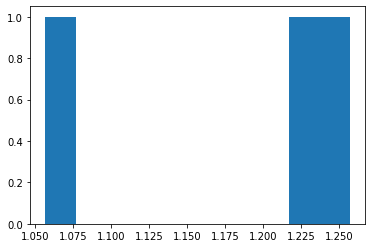

In [118]:
plt.hist(speedups)

## Significance tests

Use speedup for each replicate, only include the replicates that did not stagnate

In [119]:
speedups

4     1.222797
12    1.056454
16    1.256977
dtype: float64

We can use the ditribution of of our replicates to find the probability of getting reported result value

In [120]:
# Take the value they reported and substitute it here
REPORTED_SPEEDUP_VALUE = 3.05
# significance level
alpha = 0.05
# seed for reproducibility
seed = 12345

### Approach 1: Using CLT to get normal distribution

As the data might not be normal we sample and do mean

(array([ 10.,  35.,  90., 170., 213., 245., 161.,  61.,  11.,   4.]),
 array([1.14108378, 1.1489589 , 1.15683401, 1.16470913, 1.17258425,
        1.18045937, 1.18833448, 1.1962096 , 1.20408472, 1.21195984,
        1.21983495]),
 <a list of 10 Patch objects>)

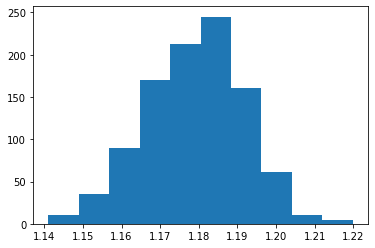

In [121]:
import numpy as np

# sample 50 items 1000 times
n = 50
sampleTimes = 1000

sampleNumber = 0
means = []
while sampleNumber < sampleTimes: 
    sampleMean = np.mean(np.random.choice(speedups,n))
    means.append(sampleMean)
    sampleNumber += 1

plt.hist(means)

Calculate the critical value for our significance level to compare the t-statistic to:

In [122]:
criticalValue = stats.t.ppf(1-alpha, n-1)
criticalValue

1.6765508919142629

Calculate the test statistic for the difference of our overall mean and the reported mean

In [128]:
overallMeasuredMean = np.mean(means)
testStatistic = (overallMeasuredMean - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(1000))
abs(testStatistic)

551.5251774946877

And now calculate the p-value of the testStatistic

In [129]:
pValue = stats.t.sf(abs(testStatistic), df=n-1)
# store the significance result for later
cltApproachSignificant = pValue < alpha
pValue

6.683720277321956e-95

### Approach 2: Assuming t-test assumptions are met

Alternatively using the samples we have only, assuming t-test assumptions are met

In [ ]:
std = statistics.stdev(speedups)
std

In [125]:
N = len(speedups)

testStatistic = (measuredSpeedup - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(N))
print("t-Test statistic:", abs(testStatistic))

t-Test statistic: 30.414649776082555


In [126]:
criticalValue = stats.t.ppf(1-alpha, N)
print("Critical value for current statistic and alpha=0.05: ", criticalValue)
# calculate our p-value
pValue = stats.t.sf(abs(testStatistic), df=N-1)
print("P-value of their result coming from our distribution:", pValue)
# store significance level for later
assumingSignificant =  pValue < alpha
print("Significant difference - reject H0?:",)

Critical value for current statistic and alpha=0.05:  2.3533634348018264
P-value of their result coming from our distribution: 0.0005396359059699447
Significant difference - reject H0?:


## Verdict

In [127]:
print("Approach 1 significant:", cltApproachSignificant)
print("Approach 2 significant:", assumingSignificant)

Approach 1 significant: True
Approach 2 significant: True
